In [2]:
!pip install -U langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.25
    Uninstalling langchain-core-0.3.25:
      Successfully uninstalled langchain-core-0.3.25
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.12
    Uninstalling langchain-0.3.12:
      Successfully uninstalled langchain-0.3.12


In [3]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


**Step 1 :Loading Dataset**

In [4]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import pandas as pd

# Load dataset
df = pd.read_csv('/content/Train-sheet.csv')

**Step 2 : Data Cleaning & Feature Engineering**

**Text Preprocessing**

In [5]:
df = df[['reviews', 'Category']]
# Load SpaCy English model
nlp = spacy.load('en_core_web_sm')

def preprocess_text_spacy(text):
    # Process text with SpaCy
    doc = nlp(text)

    # Lowercasing, removing stopwords, and lemmatization
    tokens = [
        token.lemma_.lower()  # Lemmatize and lowercase the token
        for token in doc
        if token.is_alpha  # Check for alphabetic tokens only (no parentheses)
        and token.lemma_.lower() not in STOP_WORDS  # Check against lemmatized tokens
    ]

    # Join tokens back into a string
    return " ".join(tokens)

# Apply preprocessing
df['preprocessed_text'] = df['reviews'].apply(preprocess_text_spacy)

In [6]:
df

,reviews,Category,preprocessed_text
0,Adequate ..|| Once again proves they sale the ...,['Build Quality'],adequate prove sale quality quality
1,Poor screen quality|| Don't Fall on Youtubers ...,"['Camera', 'Performance', 'Screen', 'Build Qua...",poor screen fall youtubers experience shift gr...
2,Very good phone with excellent features and pe...,"['Battery', 'Performance', 'Screen', 'Price']",good phone excellent feature gift excellent va...
3,Front Camera is bad.|| Save yourself and don't...,"['Camera', 'Battery', 'Price']",camera save fall pay youtube value money read ...
4,Camera Beast 😍😍|| Vivo X60 Pro Review|| perfec...,"['Camera', 'Price']",camera beast vivo pro perfect configuration go...
...,...,...,...
259,I prefer you must buy it.|| Best budget smart ...,['Price'],prefer buy best budget smart phone available o...
260,Loved it! Only unboxed & all original accessor...,"['Performance', 'Screen', 'Price']",love unboxed original want return plus renew p...
261,Phone is not good|| About to small Android ver...,[],phone small android version
262,I am luckiest to have this elegant self create...,[],lucky elegant self create work art technology ...


In [7]:
df=df.drop(['reviews'],axis=1)

**ONE HOT ENCODING ON Category**

In [8]:
# df = df[df['Category'] != "[]"]

df['Category'] = df['Category'].astype(str)

# Step 2: Remove square brackets, split the string, and strip spaces
df['Category'] = df['Category'].str.replace(r"[\[\]']", "", regex=True).str.split(",").apply(lambda x: [item.strip() for item in x])

# Step 3: Get unique categories from the 'Category' column
unique_categories = set(cat for sublist in df['Category'] for cat in sublist)

# Step 4: One-hot encode each category
for category in unique_categories:
    df[category] = df['Category'].apply(lambda x: 1 if category in x else 0)

# Step 5: Drop columns only if they exist (if needed for cleanup)
columns_to_drop = ["'", "[", "]", ","]
existing_columns = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_columns, errors="ignore")

In [9]:
df

,Category,preprocessed_text,Screen,,Battery,Performance,Design,Camera,Build Quality,Price
0,[Build Quality],adequate prove sale quality quality,0,0,0,0,0,0,1,0
1,"[Camera, Performance, Screen, Build Quality]",poor screen fall youtubers experience shift gr...,1,0,0,1,0,1,1,0
2,"[Battery, Performance, Screen, Price]",good phone excellent feature gift excellent va...,1,0,1,1,0,0,0,1
3,"[Camera, Battery, Price]",camera save fall pay youtube value money read ...,0,0,1,0,0,1,0,1
4,"[Camera, Price]",camera beast vivo pro perfect configuration go...,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
259,[Price],prefer buy best budget smart phone available o...,0,0,0,0,0,0,0,1
260,"[Performance, Screen, Price]",love unboxed original want return plus renew p...,1,0,0,1,0,0,0,1
261,[],phone small android version,0,1,0,0,0,0,0,0
262,[],lucky elegant self create work art technology ...,0,1,0,0,0,0,0,0


**DATA VISUALIZATION**

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataset is loaded into a DataFrame named df

# Define the allowed categories
category_columns = ['Design', 'Build Quality', 'Performance', 'Screen', 'Price', 'Camera', 'Battery']

# Sum the one-hot encoded values for each category
category_sums = df[category_columns].sum().sort_values(ascending=False)

# Convert to DataFrame for plotting
category_df = category_sums.reset_index()
category_df.columns = ['Category', 'Count']



**Bar Plot**

<ipython-input-11-b72b03c55bdb>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Category', data=category_df, palette='viridis')


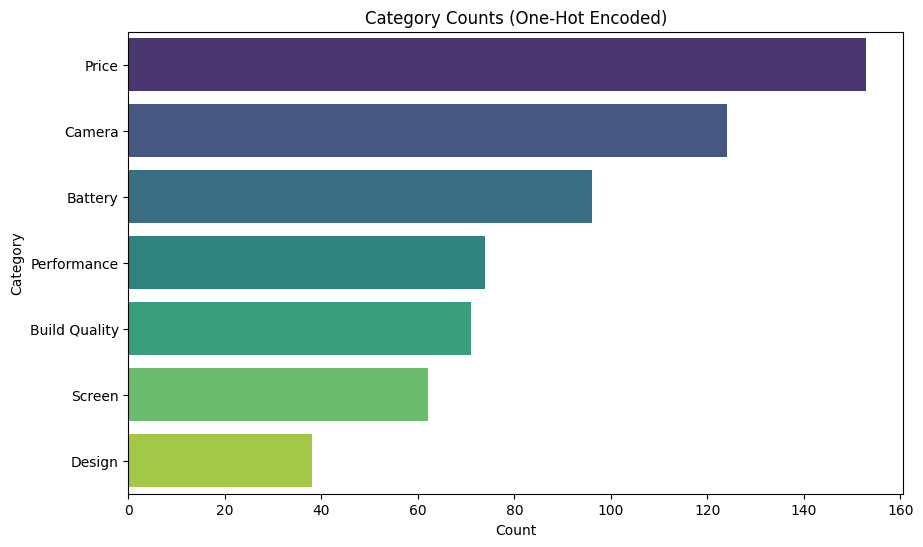

In [11]:
# Plot 1: Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Category', data=category_df, palette='viridis')
plt.title('Category Counts (One-Hot Encoded)')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()




**Pie Chart**

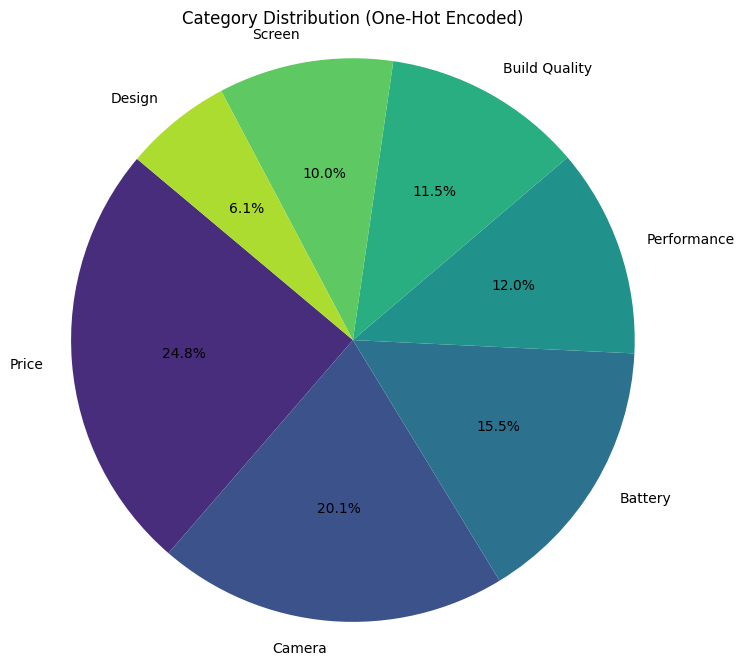

In [12]:
# Plot 2: Pie Chart
plt.figure(figsize=(8, 8))
plt.pie(category_df['Count'], labels=category_df['Category'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('viridis', len(category_df)))
plt.title('Category Distribution (One-Hot Encoded)')
plt.axis('equal')
plt.show()



**Horizontal Bar Chart**

<ipython-input-13-81043247a162>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Category', data=category_df, palette='coolwarm')


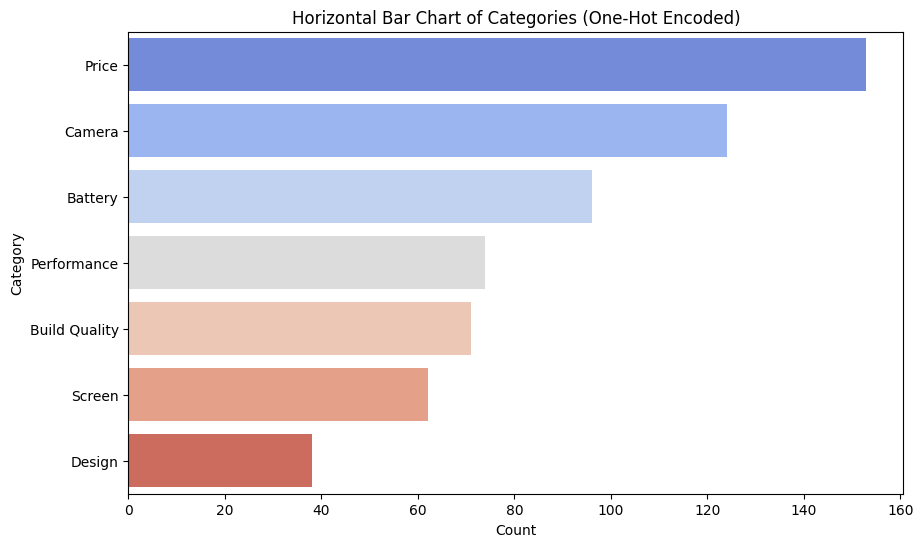

In [13]:
# Plot 3: Horizontal Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Count', y='Category', data=category_df, palette='coolwarm')
plt.title('Horizontal Bar Chart of Categories (One-Hot Encoded)')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

**Line Plot**

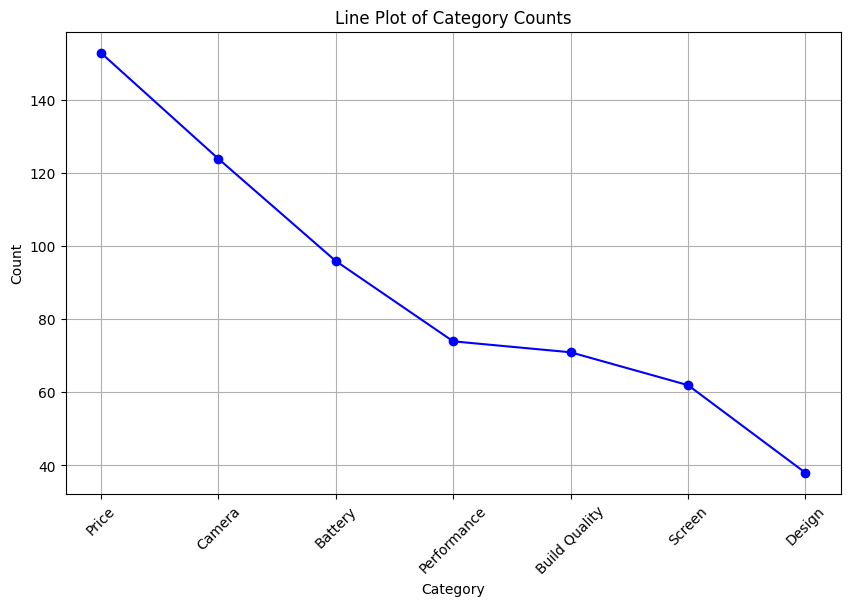

In [14]:
# Plot 4: Line Plot
plt.figure(figsize=(10, 6))
plt.plot(category_df['Category'], category_df['Count'], marker='o', linestyle='-', color='b')
plt.title('Line Plot of Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**Scatter Plot**

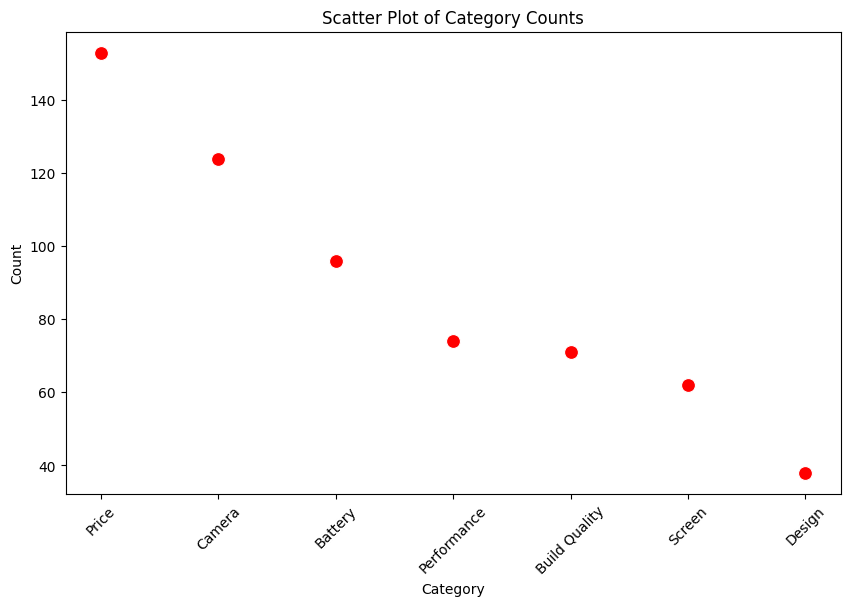

In [15]:
# Plot 5: Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Category', y='Count', data=category_df, s=100, color='red')
plt.title('Scatter Plot of Category Counts')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

**Heatmap**

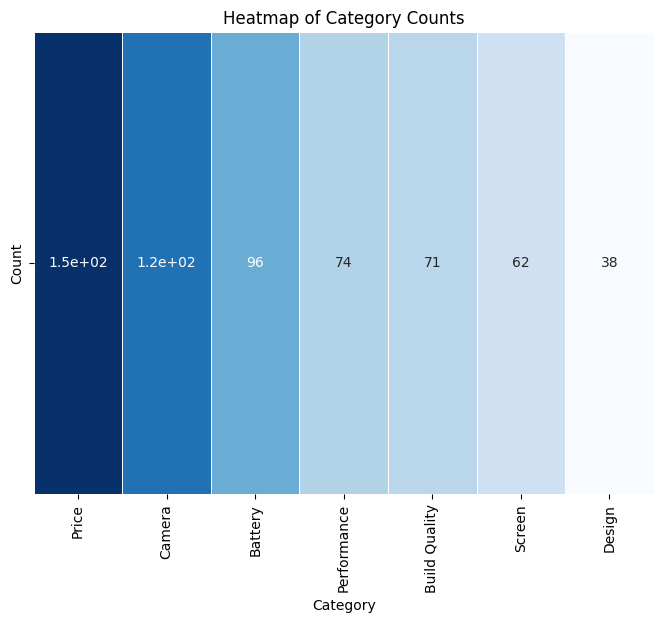

In [16]:
# Plot 6: Heatmap
plt.figure(figsize=(8, 6))
category_matrix = category_df.set_index('Category').T
sns.heatmap(category_matrix, annot=True, cmap='Blues', cbar=False, linewidths=.5)
plt.title('Heatmap of Category Counts')
plt.show()

**Text to Embeddings**

In [17]:
def generate_embeddings(review):
    return  model.encode(review)

# Apply embedding generation to the 'reviews' column
df['review_embeddings'] = df['preprocessed_text'].apply(generate_embeddings)

# Display the dataframe with embeddings
df

,Category,preprocessed_text,Screen,,Battery,Performance,Design,Camera,Build Quality,Price,review_embeddings
0,[Build Quality],adequate prove sale quality quality,0,0,0,0,0,0,1,0,"[-0.032124795, -0.008650639, 0.03171529, -0.08..."
1,"[Camera, Performance, Screen, Build Quality]",poor screen fall youtubers experience shift gr...,1,0,0,1,0,1,1,0,"[-0.09376625, -0.042272657, 0.04979517, -0.091..."
2,"[Battery, Performance, Screen, Price]",good phone excellent feature gift excellent va...,1,0,1,1,0,0,0,1,"[-0.14893596, 0.10088719, 0.08829404, -0.06328..."
3,"[Camera, Battery, Price]",camera save fall pay youtube value money read ...,0,0,1,0,0,1,0,1,"[-0.123040564, 0.03897895, 0.048208985, -0.067..."
4,"[Camera, Price]",camera beast vivo pro perfect configuration go...,0,0,0,0,0,1,0,1,"[-0.080006644, 3.1939984e-05, 0.08784843, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...
259,[Price],prefer buy best budget smart phone available o...,0,0,0,0,0,0,0,1,"[-0.04600004, 0.06112456, 0.059878174, -0.0229..."
260,"[Performance, Screen, Price]",love unboxed original want return plus renew p...,1,0,0,1,0,0,0,1,"[-0.13847776, 0.06337772, 0.097479925, -0.0217..."
261,[],phone small android version,0,1,0,0,0,0,0,0,"[0.016589299, 0.09485715, 0.09037396, -0.08716..."
262,[],lucky elegant self create work art technology ...,0,1,0,0,0,0,0,0,"[-0.0768591, 0.047309827, 0.0034005782, -0.039..."


In [18]:
# df = df[df['Category'] != "[]"]

df['Category'] = df['Category'].astype(str)

# Step 2: Remove square brackets, split the string, and strip spaces
df['Category'] = df['Category'].str.replace(r"[\[\]']", "", regex=True).str.split(",").apply(lambda x: [item.strip() for item in x])

# Step 3: Get unique categories from the 'Category' column
unique_categories = set(cat for sublist in df['Category'] for cat in sublist)

# Step 4: One-hot encode each category
for category in unique_categories:
    df[category] = df['Category'].apply(lambda x: 1 if category in x else 0)

# Step 5: Drop columns only if they exist (if needed for cleanup)
columns_to_drop = ["'", "[", "]", ","]
existing_columns = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=existing_columns, errors="ignore")

df=df.drop(['Category','preprocessed_text'],axis=1)

**Cleaned Data after preprocessing**

In [19]:
df

,Screen,,Battery,Performance,Design,Camera,Build Quality,Price,review_embeddings
0,0,0,0,0,0,0,1,0,"[-0.032124795, -0.008650639, 0.03171529, -0.08..."
1,1,0,0,1,0,1,1,0,"[-0.09376625, -0.042272657, 0.04979517, -0.091..."
2,1,0,1,1,0,0,0,1,"[-0.14893596, 0.10088719, 0.08829404, -0.06328..."
3,0,0,1,0,0,1,0,1,"[-0.123040564, 0.03897895, 0.048208985, -0.067..."
4,0,0,0,0,0,1,0,1,"[-0.080006644, 3.1939984e-05, 0.08784843, -0.0..."
...,...,...,...,...,...,...,...,...,...
259,0,0,0,0,0,0,0,1,"[-0.04600004, 0.06112456, 0.059878174, -0.0229..."
260,1,0,0,1,0,0,0,1,"[-0.13847776, 0.06337772, 0.097479925, -0.0217..."
261,0,1,0,0,0,0,0,0,"[0.016589299, 0.09485715, 0.09037396, -0.08716..."
262,0,1,0,0,0,0,0,0,"[-0.0768591, 0.047309827, 0.0034005782, -0.039..."


**Step 3 : Model training & building**

**Logistic Regression**  Accuracy Score: 0.49056603773584906

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import joblib  # For saving the best model

# Step 1: Prepare the data
# Features (excluding 'review_embeddings' and target categories)
X = df.drop(columns=["review_embeddings", "Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"])

# Concatenate the embeddings to the features
X = np.hstack((X, np.array(df['review_embeddings'].tolist())))

# Combine multiple columns into a single label for multi-class classification
y = df[["Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"]].apply(
    lambda row: ",".join(row.astype(str)), axis=1
)

# Step 2: Initialize K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
fold_accuracies = []
best_accuracy = 0
best_model = None

# Step 3: Perform K-Fold Cross-Validation
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"\n--- Fold {fold + 1} ---")
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Initialize Logistic Regression Model
    logreg_model = LogisticRegression(
        solver='lbfgs',          # Optimization algorithm
        max_iter=1000,           # Maximum iterations for convergence
        multi_class='multinomial', # For multi-class classification
        random_state=42          # For reproducibility
    )

    # Train the model
    logreg_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = logreg_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

    print("Accuracy:", accuracy)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = logreg_model

# Step 4: Display the results
print("\n--- K-Fold Results ---")
for i, acc in enumerate(fold_accuracies, 1):
    print(f"Fold {i}: {acc}")
print(f"Best Accuracy: {best_accuracy}")

# # Step 5: Save the best model
# if best_model is not None:
#     joblib.dump(best_model, "best_logistic_regression_model.pkl")
#     print("\nBest model saved as 'best_logistic_regression_model.pkl'")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



--- Fold 1 ---
Accuracy: 0.4339622641509434
Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       1.00      1.00      1.00         6
0,0,0,0,0,0,1       0.00      0.00      0.00         1
0,0,0,0,0,1,0       1.00      1.00      1.00         2
0,0,0,0,1,0,0       0.28      1.00      0.43         5
0,0,0,0,1,1,0       1.00      1.00      1.00         3
0,0,0,1,0,0,0       0.00      0.00      0.00         2
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       0.00      0.00      0.00         1
0,0,1,0,1,0,0       0.00      0.00      0.00         2
0,0,1,0,1,1,0       0.00      0.00      0.00         2
0,0,1,0,1,1,1       0.00      0.00      0.00         1
0,0,1,1,0,1,0       0.00      0.00      0.00         1
0,1,1,0,0,0,0       0.00      0.00      0.00         1
1,0,0,0,0,0,0       0.00      0.00      0.00         1
1,0,0,0,1,0,0       0.00      0.00      0.00         2
1,0,0,1,1,0,0       0.00      0.00      0.00       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/l

Accuracy: 0.4716981132075472
Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       1.00      1.00      1.00         6
0,0,0,0,0,1,0       1.00      0.50      0.67         2
0,0,0,0,1,0,0       0.23      1.00      0.37         5
0,0,0,0,1,1,0       1.00      0.67      0.80         3
0,0,0,0,1,1,1       0.00      0.00      0.00         1
0,0,0,1,0,0,0       0.00      0.00      0.00         1
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       0.00      0.00      0.00         1
0,0,1,0,0,1,1       0.00      0.00      0.00         1
0,0,1,0,1,0,0       0.00      0.00      0.00         2
0,0,1,0,1,1,0       1.00      1.00      1.00         1
0,1,0,0,0,0,0       0.00      0.00      0.00         1
0,1,0,0,0,1,1       1.00      1.00      1.00         1
0,1,0,1,1,0,1       0.00      0.00      0.00         1
1,0,0,0,0,0,0       0.00      0.00      0.00         2
1,0,0,0,1,0,0       0.00      0.00      0.00         1
1,0,0,1,0,0,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/l

Accuracy: 0.49056603773584906
Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       1.00      1.00      1.00         6
0,0,0,0,0,1,0       1.00      1.00      1.00         3
0,0,0,0,1,0,0       0.35      1.00      0.52         6
0,0,0,0,1,1,0       1.00      0.33      0.50         3
0,0,0,0,1,1,1       0.00      0.00      0.00         1
0,0,0,1,0,0,0       0.00      0.00      0.00         1
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       0.00      0.00      0.00         1
0,0,1,0,1,0,0       0.00      0.00      0.00         2
0,0,1,0,1,0,1       0.00      0.00      0.00         1
0,0,1,0,1,1,0       1.00      1.00      1.00         1
0,0,1,1,0,0,0       0.00      0.00      0.00         1
0,0,1,1,1,0,1       0.00      0.00      0.00         1
0,1,0,0,0,1,1       1.00      1.00      1.00         1
0,1,1,0,1,0,0       0.00      0.00      0.00         1
1,0,0,0,0,0,0       1.00      0.50      0.67         2
1,0,0,0,0,1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/l

**SVM** Accuracy Score: 0.7169811320754716

In [21]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import joblib  # For saving the model
import numpy as np
import pandas as pd

# Step 1: Prepare the data
# Features (excluding 'review_embeddings' and target categories)
X = df.drop(columns=["review_embeddings", "Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"])

# Concatenate the embeddings to the features
X = np.hstack((X, np.array(df['review_embeddings'].tolist())))

# Combine multiple columns into a single label for multi-class classification
y = df[["Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"]].apply(
    lambda row: ",".join(row.astype(str)), axis=1
)

# Step 2: K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
highest_accuracy = 0
best_model = None

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold + 1}:")

    # Split data into training and testing for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the SVM model
    svm_model = SVC(
        kernel='rbf',       # Radial Basis Function kernel
        C=1.0,              # Regularization parameter
        gamma='scale',      # Kernel coefficient
        random_state=42     # For reproducibility
    )

    # Train the model
    svm_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Save the model with the highest accuracy
    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_model = svm_model

    # Print classification report for the current fold
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(highest_accuracy)
# # Step 3: Save the best model
# if best_model:
#     joblib.dump(best_model, 'best_svm_model.pkl')
#     print(f"\nBest model saved with accuracy: {highest_accuracy}")



Fold 1:
Accuracy: 0.6226415094339622

Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       1.00      1.00      1.00         6
0,0,0,0,0,0,1       0.00      0.00      0.00         1
0,0,0,0,0,1,0       1.00      1.00      1.00         2
0,0,0,0,1,0,0       0.33      1.00      0.50         5
0,0,0,0,1,1,0       1.00      1.00      1.00         3
0,0,0,1,0,0,0       1.00      0.50      0.67         2
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       0.00      0.00      0.00         1
0,0,1,0,1,0,0       0.00      0.00      0.00         2
0,0,1,0,1,1,0       1.00      1.00      1.00         2
0,0,1,0,1,1,1       0.00      0.00      0.00         1
0,0,1,1,0,1,0       0.00      0.00      0.00         1
0,1,1,0,0,0,0       0.00      0.00      0.00         1
1,0,0,0,0,0,0       1.00      1.00      1.00         1
1,0,0,0,1,0,0       1.00      0.50      0.67         2
1,0,0,1,1,0,0       0.00      0.00      0.00         1
1,

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predic

**KNN** Accuracy Score: 0.7121212121212122

In [22]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Step 1: Prepare the data
# Features (excluding 'review_embeddings' and target categories)
X = df.drop(columns=["review_embeddings", "Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"])

# Concatenate the embeddings to the features
X = np.hstack((X, np.array(df['review_embeddings'].tolist())))

# Combine multiple columns into a single label for multi-class classification
y = df[["Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"]].apply(
    lambda row: ",".join(row.astype(str)), axis=1
)

# Step 2: Initialize the KNN model
knn_model = KNeighborsClassifier(
    n_neighbors=5,    # Number of neighbors (you can tune this)
    weights='uniform',  # Weight function ('uniform' or 'distance')
    metric='euclidean'  # Distance metric (e.g., 'euclidean', 'manhattan')
)

# Step 3: K-Fold Cross-Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds
cross_val_scores = cross_val_score(knn_model, X, y, cv=kfold, scoring='accuracy')

# Print cross-validation scores
print("Cross-Validation Accuracy Scores:", cross_val_scores)
print("Mean Cross-Validation Accuracy:", np.mean(cross_val_scores))

# Step 4: Train and Evaluate the Model
knn_model.fit(X, y)

# Evaluate on the same dataset (optional, if cross-validation is sufficient)
y_pred = knn_model.predict(X)
print("\nClassification Report:")
print(classification_report(y, y_pred))

print("Accuracy Score:", accuracy_score(y, y_pred))


Cross-Validation Accuracy Scores: [0.37735849 0.41509434 0.49056604 0.50943396 0.38461538]
Mean Cross-Validation Accuracy: 0.4354136429608128

Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       1.00      1.00      1.00        29
0,0,0,0,0,0,1       0.00      0.00      0.00         1
0,0,0,0,0,1,0       0.91      0.91      0.91        11
0,0,0,0,1,0,0       0.85      0.81      0.83        27
0,0,0,0,1,0,1       0.00      0.00      0.00         1
0,0,0,0,1,1,0       0.68      0.87      0.76        15
0,0,0,0,1,1,1       0.60      0.75      0.67         4
0,0,0,1,0,0,0       1.00      0.83      0.91         6
0,0,0,1,1,0,0       1.00      0.25      0.40         4
0,0,1,0,0,0,0       0.86      1.00      0.92         6
0,0,1,0,0,1,1       0.00      0.00      0.00         2
0,0,1,0,1,0,0       0.60      0.30      0.40        10
0,0,1,0,1,0,1       0.00      0.00      0.00         2
0,0,1,0,1,1,0       1.00      1.00      1.00         6
0,0,1,0,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**RandomForestClassifier** Accuracy Score: 0.8113207547169812

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import joblib  # For saving the model
import numpy as np
import pandas as pd

# Step 1: Prepare the data
# Features (excluding 'review_embeddings' and target categories)
X = df.drop(columns=["review_embeddings", "Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"])

# Concatenate the embeddings to the features
X = np.hstack((X, np.array(df['review_embeddings'].tolist())))

# Combine multiple columns into a single label for multi-class classification
y = df[["Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"]].apply(
    lambda row: ",".join(row.astype(str)), axis=1
)

# Step 2: K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
highest_accuracy = 0
best_model = None

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold + 1}:")

    # Split data into training and testing for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the Random Forest model
    rf_model = RandomForestClassifier(
        n_estimators=100,        # Number of trees in the forest
        random_state=42,         # For reproducibility
        n_jobs=-1                # Use all processors for faster training
    )

    # Train the model
    rf_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = rf_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Save the model with the highest accuracy
    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_model = rf_model

    # Print classification report for the current fold
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(highest_accuracy)




/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(



Fold 1:
Accuracy: 0.7547169811320755

Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       0.67      1.00      0.80         6
0,0,0,0,0,0,1       0.00      0.00      0.00         1
0,0,0,0,0,1,0       1.00      1.00      1.00         2
0,0,0,0,1,0,0       0.56      1.00      0.71         5
0,0,0,0,1,1,0       1.00      1.00      1.00         3
0,0,0,1,0,0,0       1.00      0.50      0.67         2
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       1.00      1.00      1.00         1
0,0,1,0,1,0,0       0.00      0.00      0.00         2
0,0,1,0,1,1,0       1.00      1.00      1.00         2
0,0,1,0,1,1,1       1.00      1.00      1.00         1
0,0,1,1,0,1,0       0.00      0.00      0.00         1
0,1,1,0,0,0,0       0.00      0.00      0.00         1
1,0,0,0,0,0,0       1.00      1.00      1.00         1
1,0,0,0,1,0,0       0.50      0.50      0.50         2
1,0,0,1,1,0,0       1.00      1.00      1.00         1
1,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.8113207547169812

Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       0.60      1.00      0.75         6
0,0,0,0,0,1,0       1.00      1.00      1.00         2
0,0,0,0,1,0,0       0.62      1.00      0.77         5
0,0,0,0,1,0,1       0.00      0.00      0.00         1
0,0,0,0,1,1,0       1.00      0.67      0.80         3
0,0,0,0,1,1,1       1.00      1.00      1.00         1
0,0,0,1,0,0,0       1.00      1.00      1.00         1
0,0,1,0,0,0,0       1.00      0.50      0.67         2
0,0,1,0,0,1,1       1.00      1.00      1.00         1
0,0,1,0,1,0,0       1.00      0.50      0.67         2
0,0,1,0,1,1,0       0.50      1.00      0.67         1
0,0,1,0,1,1,1       1.00      1.00      1.00         1
0,1,0,0,0,1,1       1.00      1.00      1.00         1
0,1,0,0,1,0,0       0.00      0.00      0.00         1
0,1,0,1,1,0,1       1.00      1.00      1.00         1
1,0,0,0,0,0,0       1.00      1.00      1.00         1
1,0,0,0,1,0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7547169811320755

Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       0.67      1.00      0.80         6
0,0,0,0,0,1,0       1.00      0.50      0.67         2
0,0,0,0,1,0,0       0.42      1.00      0.59         5
0,0,0,0,1,1,0       1.00      0.67      0.80         3
0,0,0,0,1,1,1       1.00      1.00      1.00         1
0,0,0,1,0,0,0       0.00      0.00      0.00         1
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       1.00      1.00      1.00         1
0,0,1,0,0,1,1       1.00      1.00      1.00         1
0,0,1,0,1,0,0       1.00      0.50      0.67         2
0,0,1,0,1,1,0       1.00      1.00      1.00         1
0,1,0,0,0,0,0       0.00      0.00      0.00         1
0,1,0,0,0,1,1       1.00      1.00      1.00         1
0,1,0,1,1,0,1       1.00      1.00      1.00         1
1,0,0,0,0,0,0       0.33      0.50      0.40         2
1,0,0,0,1,0,0       0.00      0.00      0.00         1
1,0,0,1,0,0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7547169811320755

Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       0.75      1.00      0.86         6
0,0,0,0,0,1,0       1.00      1.00      1.00         3
0,0,0,0,1,0,0       0.60      1.00      0.75         6
0,0,0,0,1,1,0       0.60      1.00      0.75         3
0,0,0,0,1,1,1       1.00      1.00      1.00         1
0,0,0,1,0,0,0       1.00      1.00      1.00         1
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       1.00      1.00      1.00         1
0,0,1,0,1,0,0       1.00      1.00      1.00         2
0,0,1,0,1,0,1       0.00      0.00      0.00         1
0,0,1,0,1,1,0       1.00      1.00      1.00         1
0,0,1,1,0,0,0       1.00      1.00      1.00         1
0,0,1,1,1,0,1       0.00      0.00      0.00         1
0,1,0,0,0,1,1       1.00      1.00      1.00         1
0,1,1,0,1,0,0       0.00      0.00      0.00         1
1,0,0,0,0,0,0       1.00      0.50      0.67         2
1,0,0,0,0,1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy: 0.7307692307692307

Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       0.50      1.00      0.67         5
0,0,0,0,0,1,0       0.50      1.00      0.67         2
0,0,0,0,1,0,0       0.75      0.50      0.60         6
0,0,0,0,1,1,0       0.75      1.00      0.86         3
0,0,0,0,1,1,1       0.00      0.00      0.00         1
0,0,0,1,0,0,0       0.00      0.00      0.00         1
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       1.00      1.00      1.00         1
0,0,1,0,1,0,0       0.50      0.50      0.50         2
0,0,1,0,1,0,1       0.00      0.00      0.00         1
0,0,1,0,1,1,0       1.00      1.00      1.00         1
0,0,1,1,0,0,0       1.00      1.00      1.00         1
0,1,0,0,0,1,1       1.00      1.00      1.00         1
1,0,0,0,0,0,0       1.00      0.50      0.67         2
1,0,0,0,1,0,0       0.50      0.50      0.50         2
1,0,0,0,1,0,1       0.00      0.00      0.00         1
1,0,0,1,0,1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Lightgbm** Accuracy: 0.7924528301886793

In [24]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
import joblib  # For saving the model
import numpy as np
import pandas as pd

# Step 1: Prepare the data
# Features (excluding 'review_embeddings' and target categories)
X = df.drop(columns=["review_embeddings", "Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"])

# Concatenate the embeddings to the features
X = np.hstack((X, np.array(df['review_embeddings'].tolist())))

# Combine multiple columns into a single label for multi-class classification
y = df[["Camera", "Design", "Battery", "Build Quality", "Price", "Performance", "Screen"]].apply(
    lambda row: ",".join(row.astype(str)), axis=1
)

# Step 2: K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
highest_accuracy = 0
best_model = None

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    print(f"\nFold {fold + 1}:")

    # Split data into training and testing for the current fold
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Define the LightGBM model
    lgb_model = lgb.LGBMClassifier(
        objective='multiclass',    # Specify multiclass classification
        num_class=7,               # Number of classes
        n_estimators=100,          # Number of trees
        random_state=42,           # For reproducibility
        n_jobs=-1                  # Use all processors for faster training
    )

    # Train the model
    lgb_model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = lgb_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")

    # Save the model with the highest accuracy
    if accuracy > highest_accuracy:
        highest_accuracy = accuracy
        best_model = lgb_model

    # Print classification report for the current fold
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print(highest_accuracy)

# Step 3: Save the best model
if best_model:
    joblib.dump(best_model, 'best_lgb_model.pkl')
    print(f"\nBest model saved with accuracy: {highest_accuracy}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

Accuracy: 0.7547169811320755

Classification Report:
               precision    recall  f1-score   support

0,0,0,0,0,0,0       1.00      1.00      1.00         6
0,0,0,0,0,1,0       1.00      0.50      0.67         2
0,0,0,0,1,0,0       0.62      1.00      0.77         5
0,0,0,0,1,1,0       0.67      0.67      0.67         3
0,0,0,0,1,1,1       1.00      1.00      1.00         1
0,0,0,1,0,0,0       0.00      0.00      0.00         1
0,0,0,1,1,0,0       0.00      0.00      0.00         1
0,0,1,0,0,0,0       1.00      1.00      1.00         1
0,0,1,0,0,1,1       1.00      1.00      1.00         1
0,0,1,0,1,0,0       0.33      0.50      0.40         2
0,0,1,0,1,1,0       1.00      1.00      1.00         1
0,0,1,0,1,1,1       0.00      0.00      0.00         0
0,1,0,0,0,0,0       0.00      0.00      0.00         1
0,1,0,0,0,1,1       1.00      1.00      1.00         1
0,1,0,1,1,0,1       1.00      1.00      1.00         1
1,0,0,0,0,0,0       0.50      0.50      0.50         2
1,0,0,0,1,0

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted 

**Step 4 : Model deployment** : After comparing acuuracy and all other metrics of model LightGBM has better performance than other so we are deploying LightGBM in the above code.

**Step 5: Model Validation**

In [39]:
def classify_reviews(input_file, output_file):
    # Load the Excel file
    new_df = pd.read_excel(input_file)

    # Preprocess the reviews
    new_df["preprocessed_reviews"] = new_df["review"].apply(preprocess_text_spacy)

    # Generate embeddings for the new reviews
    new_df["embeddings"] = new_df["preprocessed_reviews"].apply(generate_embeddings)

    # Convert embeddings to a matrix
    embeddings_matrix = np.array(new_df["embeddings"].tolist())

    # (Optional) Add any additional features used during training
    new_df["review_length"] = new_df["preprocessed_reviews"].apply(len)
    embeddings_matrix = np.hstack((embeddings_matrix, new_df["review_length"].values.reshape(-1, 1)))

    # Load the saved model
    loaded_model = joblib.load("best_lgb_model.pkl")

    # Check feature dimensions
    if embeddings_matrix.shape[1] != loaded_model.n_features_in_:
        raise ValueError(
            f"Feature mismatch: Model expects {loaded_model.n_features_in_} features, but input has {embeddings_matrix.shape[1]} features."
        )

    # Predict the categories
    predictions = loaded_model.predict(embeddings_matrix)

    # Add predictions back to the DataFrame
    new_df["predicted_categories"] = predictions

    # Save the results to a new Excel file
    new_df.to_excel(output_file, index=False)
    print(f"Results saved to {output_file}")

    return new_df


In [40]:
df1=classify_reviews("/content/Test-sheet.xlsx", "/content/classified_reviews.xlsx")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Results saved to /content/classified_reviews.xlsx


In [29]:
import pandas as pd

# Define the category columns
category_columns = ["Design", "Performance", "Camera", "Screen", "Battery", "Build Quality", "Price"]

# Convert the `predicted_categories` string column into separate binary columns
def split_and_assign_categories(df, category_columns):
    # Split the predicted categories string into individual binary values
    binary_values = df["predicted_categories"].str.split(",", expand=True).astype(int)
    # Assign each binary value to the respective category column
    for i, category in enumerate(category_columns):
        df[category] = binary_values[i]
    return df

# Apply the function to split and assign categories
df1 = split_and_assign_categories(df1, category_columns)

# Define the function to extract categories
def extract_categories(row):
    return [col for col in category_columns if row[col] == 1]

# Apply the function to extract categories for each row
df1["category"] = df1.apply(extract_categories, axis=1)

# Display the result
df1


,review,preprocessed_reviews,embeddings,review_length,predicted_categories,Design,Performance,Camera,Screen,Battery,Build Quality,Price,category
0,phone lit one best phone hv ever seen everyth...,phone light good phone hv flawless worth buy m...,"[-0.10104276, 0.09005312, 0.07275175, 0.001950...",51,"0,0,0,0,1,0,0",0,0,0,0,1,0,0,[Battery]
1,purchased redmi 8a 19022020 received phone de...,purchase redmi receive phone defective registe...,"[-0.060864408, -0.047989324, -0.007675072, -0....",80,"0,0,0,0,1,0,0",0,0,0,0,1,0,0,[Battery]
2,one worst producttouch responce goodcharging ...,bad producttouch responce goodcharge speed slo...,"[-0.07634116, 0.020611646, 0.025758738, -0.036...",180,"0,0,0,0,1,0,0",0,0,0,0,1,0,0,[Battery]
3,ignored negative reviews especially receiving...,ignore negative review especially receive phon...,"[-0.08188498, 0.0941605, 0.05899499, -0.007355...",282,"1,0,0,0,0,1,1",1,0,0,0,0,1,1,"[Design, Build Quality, Price]"
4,samsung galaxy m01 comes 571inch touchscreen ...,samsung galaxy come touchscreen display resolu...,"[-0.10896026, 0.0069615245, 0.047075815, 0.004...",1300,"0,0,1,0,0,0,0",0,0,1,0,0,0,0,[Camera]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,best budjet smartphone redmiit worth money ex...,good budjet smartphone redmiit worth money exc...,"[-0.13970248, 0.0651531, 0.001969047, -0.03219...",188,"0,0,0,0,1,0,0",0,0,0,0,1,0,0,[Battery]
96,please dont purchase phone via amazon phones ...,purchase phone amazon phone pass samsung quali...,"[-0.11120694, 0.04367525, 0.05414693, -0.02460...",82,"0,0,0,0,1,0,0",0,0,0,0,1,0,0,[Battery]
97,time bought iphone 7 shut went dead dud soft ...,time buy iphone shut dead dud soft restart har...,"[-0.034562465, -0.040536724, 0.03263645, -0.00...",89,"0,1,0,0,0,1,1",0,1,0,0,0,1,1,"[Performance, Build Quality, Price]"
98,ordered first sale comparing phones range sat...,order sale compare phone range satisfied phone...,"[-0.0725597, 0.06444816, 0.03309921, -0.093287...",386,"0,0,0,0,1,0,0",0,0,0,0,1,0,0,[Battery]


In [30]:
df2=df1.drop(['preprocessed_reviews','embeddings','predicted_categories','Design','Performance','Camera','Screen','Battery','Build Quality','Price','review_length'],axis=1)

In [31]:
df2

,review,category
0,phone lit one best phone hv ever seen everyth...,[Battery]
1,purchased redmi 8a 19022020 received phone de...,[Battery]
2,one worst producttouch responce goodcharging ...,[Battery]
3,ignored negative reviews especially receiving...,"[Design, Build Quality, Price]"
4,samsung galaxy m01 comes 571inch touchscreen ...,[Camera]
...,...,...
95,best budjet smartphone redmiit worth money ex...,[Battery]
96,please dont purchase phone via amazon phones ...,[Battery]
97,time bought iphone 7 shut went dead dud soft ...,"[Performance, Build Quality, Price]"
98,ordered first sale comparing phones range sat...,[Battery]


In [32]:
df2.to_excel("/content/test_output.xlsx", index=False)